In [35]:
using HDF5, EzXML, Glob, Dates, Plots, JuMP, StatsBase, Symbolics, DataFrames, CSV, Random, Distributions, Printf, LinearAlgebra, StatsPlots, KernelDensity
using CurveFit, GLM
include("/Users/jjc/CSF/CSF Dynamics Scripts/readCSF.jl")
include("/Users/jjc/CSF/CSF Dynamics Scripts/BayesianCSFtools.jl")

# Load files
datapath = "/Users/jjc/CSF/Recordings/"
path = pwd();
savepath = "/Users/jjc/CSF/"
files = glob("*.hdf5", datapath)
filenames_trunc = Vector{String}()
for i = eachindex(files)
    push!(filenames_trunc, files[i][length(datapath)+1:end-5])
end

# Initialise dataframe
df = DataFrame(filename=filenames_trunc,
    Rcsf_icm=NaN, E_icm=NaN, Ib_icm=NaN, P0_icm=NaN,
    Rcsf_mode=NaN, E_mode=NaN, Ib_mode=NaN, P0_mode=NaN,
    Rcsf_mean=NaN, E_mean=NaN, Ib_mean=NaN, P0_mean=NaN,
    Rcsf_median=NaN, E_median=NaN, Ib_median=NaN, P0_median=NaN,
    Rcsf_ml=NaN, E_ml=NaN, Ib_ml=NaN, P0_ml=NaN,
    Rcsf_std=NaN, E_std=NaN, P0_std=NaN, Ib_std=NaN,
    Rcsf_prior_mean=NaN, E_prior_mean=NaN, P0_prior_mean=NaN,
    Rcsf_prior_std=NaN, E_prior_std=NaN, P0_prior_std=NaN,
    RMSE_mode=NaN, RMSE_median=NaN, RMSE_mean=NaN, RMSE_ml=NaN, RMSE_icm=NaN, 
    R2_mode=NaN, R2_median=NaN, R2_mean=NaN, R2_ml=NaN, R2_icm=NaN,
    Pss=NaN, P_b=NaN, I_inf=NaN, P_p=NaN, inf_length=NaN, one_needle=NaN, Rn=NaN, rec_dur_s=NaN,
    inf_st=NaN, inf_en=NaN, plat_st=NaN, plat_en=NaN)

# Settings
# 1.0 = only curve fitting, 0.0 = only PV curve fitting
alpha = 1.0
num_iter = 10^5
method = "standard"
# method = "Pss"
# method = "4"
means = [15.5, 0.18, 2.8]
stddevs = [10.36, 0.14, 10.54]

# Main loop
# for fid = 100
fid=900

    chain, chisave, Ib_chain = main(files[fid], num_iter, "informative", alpha, method, means, stddevs)
    params_modes, params_medians, params_means, params_stddevs = mean_and_stddev(chain)
    
    # This will be the set of parameters with maximum likelihood 
    opt_min = findmin(chisave)[2]
    params_ml = chain[opt_min, :]

    function get_rmse(Rcsf, E, P_0, Pss, method)
        if method == "standard"
            I_b = (Data["P_b"] - P_0) / Rcsf
            rmse = calc_model_plot(I_b, E, P_0)[2]
        elseif method == "Pss"
            I_b = (Data["P_b"] - Pss) / Rcsf
            rmse = calc_model_plot(I_b, E, P_0, Pss)[2]
        else
            I_b = (Data["P_b"] - Pss) / Rcsf
            rmse = calc_model_plot(I_b, E, P_0, Pss)[2]
        end
        return rmse
    end

    df.P_b[fid] = Data["P_b"]
    df.P_p[fid] = Data["P_p"]
    df.inf_length[fid] = (Data["infusion_end_frame"] - Data["infusion_start_frame"]) # in frames
    df.Rcsf_icm[fid] = Data["Rcsf"]
    df.E_icm[fid] = Data["E"]
    df.Ib_icm[fid] = Data["I_b"]
    df.P0_icm[fid] = Data["P_0"]
    df.I_inf[fid] = Data["I_inf"]
    df.one_needle[fid] = Data["one_needle"]
    df.Rn[fid] = Data["Rn"]
    df.rec_dur_s[fid] = Data["rec_dur_s"]
    df.inf_st[fid] = Data["infusion_start_frame"]
    df.inf_en[fid] = Data["infusion_end_frame"]
    df.plat_st[fid] = Data["plateau_start"]
    df.plat_en[fid] = Data["plateau_end"]

    df.Rcsf_prior_mean[fid], df.E_prior_mean[fid], df.P0_prior_mean[fid] = means
    df.Rcsf_prior_std[fid], df.E_prior_std[fid], df.P0_prior_std[fid] = stddevs
    df.Rcsf_mode[fid], df.E_mode[fid], df.P0_mode[fid] = params_modes
    df.Rcsf_median[fid], df.E_median[fid], df.P0_median[fid] = params_medians
    df.Rcsf_mean[fid], df.E_mean[fid], df.P0_mean[fid] = params_means
    df.Rcsf_std[fid], df.E_std[fid], df.P0_std[fid] = params_stddevs
    df.Ib_mean[fid] = mean(Ib_chain)
    df.Ib_mode[fid] = StatsBase.mode(Ib_chain)
    df.Ib_median[fid] = median(Ib_chain)
    df.Ib_std[fid] = std(Ib_chain)

    if method == "standard"
        df.RMSE_mode[fid] = get_rmse(params_modes..., params_modes[3], method)
        df.RMSE_median[fid] = get_rmse(params_medians..., params_medians[3], method)
        df.RMSE_mean[fid] = get_rmse(params_means..., params_means[3], method)
        df.RMSE_ml[fid] = get_rmse(params_ml..., params_ml[3], method)
        df.R2_mode[fid] = press_vol_curve(params_modes[1], params_modes[3], icp_inf)[4]
        df.R2_median[fid] = press_vol_curve(params_medians[1], params_medians[3], icp_inf)[4]
        df.R2_mean[fid] = press_vol_curve(params_means[1], params_means[3], icp_inf)[4]
        df.R2_ml[fid] = press_vol_curve(params_ml[1], params_ml[3], icp_inf)[4]
    elseif method == "Pss"
        df.RMSE_mode[fid] = get_rmse(params_modes[1:2]..., Data["P_0"], params_modes[3], method)
        df.RMSE_median[fid] = get_rmse(params_modes[1:2]..., Data["P_0"], params_medians[3], method)
        df.RMSE_mean[fid] = get_rmse(params_modes[1:2]..., Data["P_0"], params_means[3], method)
        df.RMSE_ml[fid] = get_rmse(params_ml[1:2]..., Data["P_0"], params_ml[3], method)
        df.R2_mode[fid] = press_vol_curve(params_modes[1], params_modes[3], icp_inf)[4]
        df.R2_median[fid] = press_vol_curve(params_medians[1], params_medians[3], icp_inf)[4]
        df.R2_mean[fid] = press_vol_curve(params_means[1], params_means[3], icp_inf)[4]
        df.R2_ml[fid] = press_vol_curve(params_ml[1], params_ml[3], icp_inf)[4]
    else
        df.RMSE_mode[fid] = get_rmse(params_modes..., method)
        df.RMSE_median[fid] = get_rmse(params_medians..., method)
        df.RMSE_mean[fid] = get_rmse(params_means..., method)
        df.RMSE_ml[fid] = get_rmse(params_ml..., method)
        df.R2_mode[fid] = press_vol_curve(params_modes[1], params_modes[4], icp_inf)[4]
        df.R2_median[fid] = press_vol_curve(params_medians[1], params_medians[4], icp_inf)[4]
        df.R2_mean[fid] = press_vol_curve(params_means[1], params_means[4], icp_inf)[4]
        df.R2_ml[fid] = press_vol_curve(params_ml[1], params_ml[4], icp_inf)[4]
    end

    df.R2_icm[fid] = press_vol_curve(Data["Rcsf"], Data["P_0"], icp_inf)[4]
    df.RMSE_icm[fid] = get_rmse(Data["Rcsf"], Data["E"], Data["P_0"], Data["P_0"], "standard")
# end

# CSV.write("/Users/jjc/CSF/Results/Results_BayesSTD.csv", df)
CSV.write("/Users/jjc/Desktop/Results_BayesSTD.csv", df)



"/Users/jjc/Desktop/Results_BayesSTD.csv"

hdbs = PyObject <module 'hdbscan' from '/Users/jjc/.julia/conda/3/lib/python3.9/site-packages/hdbscan/__init__.py'>
0.926625516837839

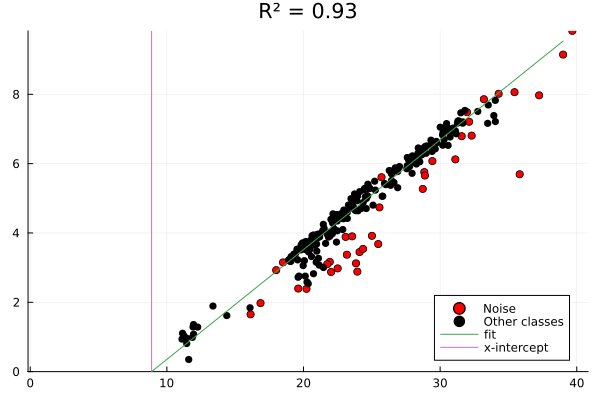

In [22]:
using HDBSCAN, Clustering

st = 2
icp = Data["ICP"][st:end]
amp = Data["AMP"][st:end]
rm = .~isnan.(amp)
rm = rm .&& amp .> 0.0
amp = amp[rm]
icp = icp[rm]

min_cluster_size=4
result = hdbscan(hcat(icp, amp)'; min_cluster_size=5, min_samples=min_cluster_size)
clusters = result.assignments
# denoised = res.>0
# scatter(icp, amp, group=res, color=colors[res .+ 1], legend=:bottomright, label="", xlabel="ICP", ylabel="AMP")

# Filter data points belonging to the non-zero cluster
nonzero_indices = findall(clusters .> 0)
nonzero_icp = icp[nonzero_indices]
nonzero_amp = amp[nonzero_indices]
nonzero_clusters = clusters[nonzero_indices]

# Plot the scatter plot with different colors for each cluster
scatter(icp[clusters .== 0], amp[clusters .== 0], color=:red, label="Noise")
scatter!(nonzero_icp, nonzero_amp, color=:black, label="Other classes", legend=:bottomright)

coefval = CurveFit.curve_fit(LinearFit, icp[nonzero_indices], amp[nonzero_indices])
c = coefval(0)
a = coefval(1)-coefval(0)
y_intercept = -c/a 
fitted_curve = coefval.(1:maximum(icp))
R2, MSE = r_squared(amp, coefval.(icp))
print(R2)

title!(@sprintf("R² = %0.2f", R2))
plot!(fitted_curve, label="fit", ylim=[0,:auto])
vline!([y_intercept], label="x-intercept")



0.23219093680381775

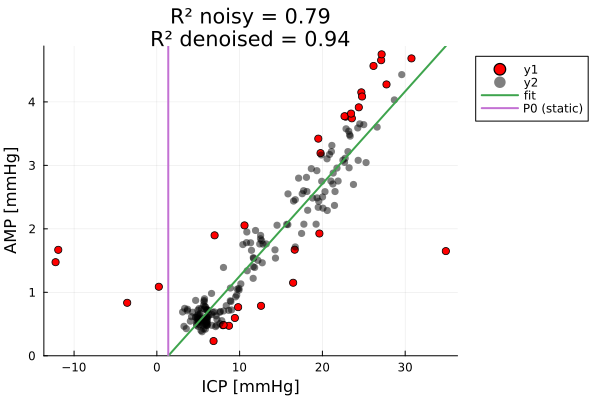

In [38]:
using Statistics
using Clustering
using GLM: lm, coef

function denoising(icp, amp, factor)
    rm = .~isnan.(amp)
    rm = rm .&& amp .> 0.1
    amp = amp[rm]
    icp = icp[rm]
    x = icp
    y = amp
    reg = lm(@formula(y ~ x), DataFrame(x=icp, y=amp))
    R2_old = r2(reg)
    residuals = y .- GLM.predict(reg, DataFrame(x=icp, y=amp))
    std_res = residuals ./ std(residuals)
    keep = abs.(std_res) .<= 1
    reg_cleaned = lm(@formula(y ~ x), DataFrame(x=icp[keep], y=amp[keep]))
    c, a = GLM.coeftable(reg_cleaned).cols[1, 1]
    R2 = r2(reg_cleaned)
    y_intercept = -c / a
    return y_intercept, R2
end

icp = Data["ICP"][2:end]
amp = Data["AMP"][2:end]
rm = .~isnan.(amp)
rm = rm .&& amp .> 0.1
amp = amp[rm]
icp = icp[rm]

print(minimum(amp))

x = icp
y = amp

reg = lm(@formula(y ~ x), DataFrame(x=icp, y=amp))
R2_old = r2(reg)
residuals = y .- GLM.predict(reg, DataFrame(x=icp, y=amp))
std_res = residuals ./ std(residuals)
keep = abs.(std_res) .<= 1

reg_cleaned = lm(@formula(y ~ x), DataFrame(x=icp[keep], y=amp[keep]))
c, a = GLM.coeftable(reg_cleaned).cols[1, 1]
R2 = r2(reg_cleaned)
y_intercept = -c / a
x_values = range(y_intercept, maximum(icp), length=100)
y_values = x_values .* a .+ c

scatter(x[.~keep], y[.~keep], color=:red)
scatter!(x[keep], y[keep], color=:black, alpha=0.5)
plot!(x_values, y_values, label="fit", legend=:outertopright, ylims=[0, :auto], xlabel="ICP [mmHg]", ylabel="AMP [mmHg]", linewidth=2)

title!(@sprintf("R² noisy = %0.2f\nR² denoised = %0.2f", R2_old, R2))
vline!([y_intercept], label="P0 (static)", linewidth=2)



In [149]:
using Statistics, LinearAlgebra

# Define the linear regression function
function linear_regression(x, y)
    X = hcat(ones(length(x)), x)
    β = X \ y
    return β
end

# Define a function to identify and remove outliers
function remove_outliers(x, y)
    β = linear_regression(x, y)
    residuals = y - (β[1] .+ β[2] .* x)
    std_res = residuals ./ std(residuals)
    keep = abs.(std_res) .<= 2
    return x[keep], y[keep]
end

# Generate some example data
x = 1:100
y = 2 .+ 3 .* x .+ randn(length(x))

# Iteratively remove outliers and refit the model
while true
    x, y = remove_outliers(x, y)
    β = linear_regression(x, y)
    r2 = 1 - sum((y - (β[1] .+ β[2] .* x)).^2) / sum((y .- mean(y)).^2)
    if isnan(r2) || length(x) < 10
        break
    end
end

# Print the final results
println("β: ", β)
println("R²: ", r2)
